## Environment

In [ ]:
%pip install numpy
%pip install matplotlib
%pip install xgboost
%pip install scikit-learn
%pip install pandas
%pip install imbalanced-learn
%pip install skl2onnx

In [26]:
# Libraries
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from xgboost import plot_importance,XGBClassifier
import json

# Generate synthetic data


In [ ]:
def generate_health_data(n_samples=100):
    # Variables para el dataset
    bmi = np.random.normal(32, 5, n_samples).clip(18.5, 50)  # BMI (kg/m^2)
    ldl = np.random.normal(140 + (bmi - 25) * 2, 30, n_samples).clip(50, 250)  # LDL (mg/dL)
    triglycerides = np.random.normal(180 + (bmi - 25) * 3, 50, n_samples).clip(50, 500)  # Triglicéridos (mg/dL)
    glucose = np.random.normal(110, 30, n_samples).clip(70, 300)  # Glucosa
    insuline = np.random.normal(15, 10, n_samples).clip(2, 100)   # Insulina
    hb1ac = np.random.choice([np.nan, *np.random.normal(5.5, 1, n_samples).clip(4, 10)], n_samples)  # HbA1c (%)
    
    # Variables adicionales
    pcr = np.random.choice([np.nan, *np.random.normal(1.5, 0.5, n_samples).clip(0.5, 10)], n_samples)
    ast = np.random.normal(20, 10, n_samples).clip(0, 100)
    alt = np.random.normal(25, 10, n_samples).clip(0, 100)
    leptin = np.random.choice([np.nan, *np.random.normal(25, 5, n_samples).clip(10, 50)], n_samples)
    
    
    # Etiquetas de diagnóstico
    # Obesidad: se priorizan BMI, LDL y triglicéridos
    obesity_label = ((bmi > 30) & (ldl > 160) & (triglycerides > 200)).astype(int)
    # Diabetes: se priorizan glucosa e insulina (aunque también se usa HbA1c)
    diabetes_label = ((glucose > 126) | (hb1ac > 6.5)).astype(int)
    # Hipertensión: se consideran anormales si la presión sistólica > 140 o diastólica > 90    
    return pd.DataFrame({
        "bmi": bmi,
        "ldl": ldl,
        "triglycerides": triglycerides,
        "glucose": glucose,
        "hb1ac": hb1ac,
        "pcr": pcr,
        "insuline": insuline,
        "ast": ast,
        "alt": alt,
        "leptin": leptin,
        "obesity_label": obesity_label,
        "diabetes_label": diabetes_label,
    })

df_health = generate_health_data(n_samples=100)
df_health.head()

NameError: name 'systolic' is not defined

# Imputation for missing data

In [18]:

# Imputación de valores faltantes
imputer = SimpleImputer(strategy="mean")
# Eliminar las columnas de etiquetas (incluyendo hipertensión)
X = df_health.drop(columns=["obesity_label", "diabetes_label", "hipertension_label"])
X_imputed = imputer.fit_transform(X)

# Convertir nuevamente a DataFrame para mantener los nombres de columnas
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)
y_obesity = df_health["obesity_label"]
y_diabetes = df_health["diabetes_label"]
y_hipertension = df_health["hipertension_label"]

# Create the fine-tunning file for Open AI

In [19]:
def prepare_chat_jsonl_sin_hipertension(df, output_file):
    with open(output_file, "w", encoding="utf-8") as f:
        for _, row in df.iterrows():
            # Prompt para obesidad
            user_prompt_obesity = (
                f"Valores clínicos:\n"
                f"BMI: {row['bmi']:.1f} (prioritario), LDL: {row['ldl']:.1f} (prioritario), "
                f"Triglicéridos: {row['triglycerides']:.1f} (prioritario), Glucosa: {row['glucose']:.1f}, "
                f"HbA1c: {row['hb1ac']:.1f}, Insulina: {row['insuline']:.1f}, PCR: {row['pcr']:.1f}, "
                f"AST: {row['ast']:.1f}, ALT: {row['alt']:.1f}, Leptina: {row['leptin']:.1f}.\n"
                f"¿Presenta signos de obesidad? (Priorizar BMI, LDL y Triglicéridos)"
            )
            obesity_completion = "Sí" if row["obesity_label"] == 1 else "No"

            obesity_chat = {
                "messages": [
                    {"role": "system", "content": "Eres un asistente que ayuda a identificar obesidad y diabetes basándote en datos clínicos."},
                    {"role": "user", "content": user_prompt_obesity},
                    {"role": "assistant", "content": obesity_completion}
                ]
            }
            f.write(json.dumps(obesity_chat) + "\n")

            # Prompt para diabetes
            user_prompt_diabetes = (
                f"Valores clínicos:\n"
                f"BMI: {row['bmi']:.1f}, LDL: {row['ldl']:.1f}, Triglicéridos: {row['triglycerides']:.1f}, "
                f"Glucosa: {row['glucose']:.1f} (prioritario), HbA1c: {row['hb1ac']:.1f}, "
                f"Insulina: {row['insuline']:.1f} (prioritario), PCR: {row['pcr']:.1f}, "
                f"AST: {row['ast']:.1f}, ALT: {row['alt']:.1f}, Leptina: {row['leptin']:.1f}.\n"
                f"¿Presenta signos de diabetes? (Priorizar Glucosa e Insulina)"
            )
            diabetes_completion = "Sí" if row["diabetes_label"] == 1 else "No"

            diabetes_chat = {
                "messages": [
                    {"role": "system", "content": "Eres un asistente que ayuda a identificar obesidad y diabetes basándote en datos clínicos."},
                    {"role": "user", "content": user_prompt_diabetes},
                    {"role": "assistant", "content": diabetes_completion}
                ]
            }
            f.write(json.dumps(diabetes_chat) + "\n")

print("✅ Archivo JSONL (sin hipertensión) generado correctamente.")

✅ Archivo JSONL (sin hipertensión) generado correctamente.


# Model training


=== Resultados para OBESIDAD ===
Precisión (Accuracy): 0.95
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.75      0.86         4

    accuracy                           0.95        20
   macro avg       0.97      0.88      0.91        20
weighted avg       0.95      0.95      0.95        20



<Figure size 1000x800 with 0 Axes>

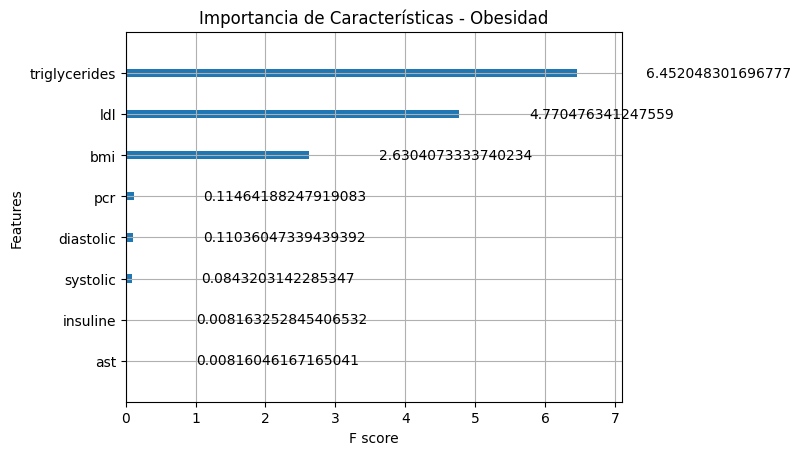


=== Resultados para DIABETES ===
Precisión (Accuracy): 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00         6

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



<Figure size 1000x800 with 0 Axes>

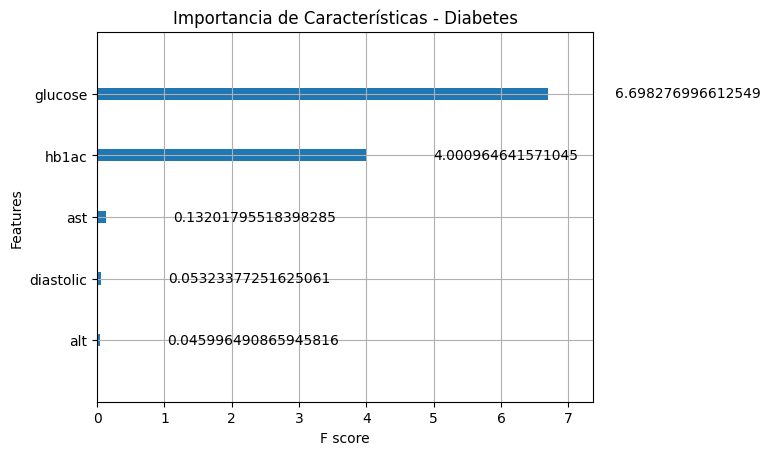

In [ ]:


def train_xgb_for_condition(X, y, condition_name):
    # División en conjunto de entrenamiento y prueba (80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Asegurarse de que X_train sea un DataFrame
    if not isinstance(X_train, pd.DataFrame):
        X_train = pd.DataFrame(X_train, columns=X.columns)
        X_test = pd.DataFrame(X_test, columns=X.columns)

    # Cálculo de scale_pos_weight para desbalance de clases
    scale_pos_weight = len(y_train[y_train == 0]) / (len(y_train[y_train == 1]) + 1e-5)

    # Creación y entrenamiento del modelo XGBoost
    xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric="logloss")
    xgb_model.fit(X_train, y_train)

    # Evaluación del modelo
    y_pred = xgb_model.predict(X_test)
    print(f"\n=== Resultados para {condition_name.upper()} ===")
    print("Precisión (Accuracy):", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Graficar la importancia de características
    if condition_name.lower() == "obesidad":
        booster = xgb_model.get_booster()
        booster.feature_names = X.columns.tolist()
        # Obtener el diccionario de importancia usando "gain"
        imp_dict = booster.get_score(importance_type="gain")
        
        # Definir el orden deseado para las variables prioritarias
        priority_features = ["bmi", "ldl", "triglycerides"]
        # Obtener los valores de gain para las variables prioritarias (si no aparecen, se asigna 0)
        priority_vals = [imp_dict.get(feat, 0) for feat in priority_features]
        
        # Para las demás variables: obtener aquellas que no están en las prioritarias
        other_features = [feat for feat in booster.feature_names if feat not in priority_features]
        # Ordenar las demás variables en forma descendente según su gain
        other_features_sorted = sorted(other_features, key=lambda feat: imp_dict.get(feat, 0), reverse=True)
        other_vals = [imp_dict.get(feat, 0) for feat in other_features_sorted]
        
        # Combinar en un solo listado: primero las prioritarias (en el orden deseado) y luego el resto
        final_features = priority_features + other_features_sorted
        final_values = [imp_dict.get(feat, 0) for feat in final_features]
        
        # Graficar usando un barplot horizontal y luego invertir el eje Y para que la primera variable aparezca en la parte superior
        plt.figure(figsize=(10, 8))
        plt.barh(final_features, final_values, color="skyblue")
        plt.xlabel("Importancia (gain)")
        plt.title("Importancia de Características - Obesidad (orden ajustado)")
        plt.gca().invert_yaxis()  # Así BMI aparecerá en la parte superior, seguido de LDL y Triglicéridos
        plt.show()
    else:
        # Para otras condiciones se usa el método estándar de XGBoost
        plt.figure(figsize=(10, 8))
        booster = xgb_model.get_booster()
        booster.feature_names = X.columns.tolist()
        plot_importance(xgb_model, importance_type="gain")
        plt.title(f"Importancia de Características - {condition_name.capitalize()}")
        plt.show()

    return xgb_model

# Entrenamiento para cada condición
obesity_model = train_xgb_for_condition(X_imputed_df, y_obesity, "obesidad")
diabetes_model = train_xgb_for_condition(X_imputed_df, y_diabetes, "diabetes")